# House Prices - Advanced Regression Techniques

## Deva Kulkarni, Jared Dec, Marc Semonick, Trevor Johnson

## October 2021

<br>

Competition Link: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

Goal: Predict sales price for each house (`SalePrice`). RMSE on log(pred) - log(actual) will be the evaluation metric. 

Inference Problem:  Given known variables about a house, accurately predict its sale price.

Deliverable: Final submission dataset should contain only the two fields `ID` and `SalePrice`. 

# Setups

Import modules

In [1]:
# basics
import math
import os 

# data manipulation/viz
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

# modeling
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.formula.api import glm 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# linear modeling
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
# tree modeling
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
# PCA
from sklearn.decomposition import PCA
# Logistic Regression
from sklearn.linear_model import LogisticRegression

#K-Fold cross-validation
from numpy import mean
from numpy import std
from numpy import absolute
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

# scale the data
from sklearn.preprocessing import StandardScaler

# Ridge Regression
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

Load in the data

In [2]:
# # optional directory set-up
# working_dir = !pwd
# train = pd.read_csv(os.path.join(working_dir[0], "../../housing_data", "train.csv"))
# test = pd.read_csv(os.path.join(working_dir[0], "../../housing_data", "test.csv"))
# sample = pd.read_csv(os.path.join(working_dir[0], "../../housing_data", "sample_submission.csv"))

# Load data (Specific to Deva)
test = pd.read_csv("../../housing_data/test.csv")
train = pd.read_csv("../../housing_data/train.csv")
sample = pd.read_csv("../../housing_data/sample_submission.csv")
print(test.shape)
print(train.shape)

(1459, 80)
(1460, 81)


In [3]:
# train =pd.read_csv('C:/Users/19258/Downloads/house-prices-advanced-regression-techniques/train.csv')
# test = pd.read_csv("C:/Users/19258/Downloads/house-prices-advanced-regression-techniques/test.csv")
# sample = pd.read_csv("C:/Users/19258/Downloads/house-prices-advanced-regression-techniques/sample_submission.csv")

# print("train shape: {}".format(train.shape))
# print("test shape: {}".format(test.shape))

## Data cleaning

Deal with missing values

In [4]:
print("Count number of missing values per variable:")
print(train.isnull().sum()[train.isnull().sum() != 0])

# function to clean the missing values
def na_clean(df):
    
    # some vars are just too missing so I remove the field
    df = df.drop(columns = ["PoolQC", "MiscFeature"])

    # replace some numeric vars w/ median
    median_replace_vars = ['LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea']
    for var in median_replace_vars:
        df[var].fillna(df[var].median(), inplace = True)
    
    # replace some num vars w/ 0
    zero_replace_vars = ['BsmtFullBath', 'BsmtHalfBath', 'GarageCars']
    for var in zero_replace_vars:
        df[var].fillna(0, inplace = True)
    
    # replace some cat vars w/ most freq value 
    df['MasVnrType'].fillna('None', inplace = True)
    df['Electrical'].fillna('SBrkr', inplace = True)
    df['MSZoning'].fillna('RL', inplace = True)
    df['SaleType'].fillna('WD', inplace = True)
    df['Utilities'].fillna('AllPub', inplace = True)
    df['KitchenQual'].fillna('TA', inplace = True)
    df['Functional'].fillna('Typ', inplace = True)

    # other cat vars just put missing if there isn't a glaring most popular category
    replace_missing_vars = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
        'BsmtFinType2', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'Fence', 'Exterior1st', 
        'Exterior2nd', 'FireplaceQu']
    for var in replace_missing_vars:
        df[var].fillna("Missing", inplace = True)

    return df

train = na_clean(train)
test = na_clean(test)

# make sure there are no more missing values
print("\nNumber of missing values after running na_clean()")
print("Missing values in train: {}".format(train.isnull().sum().sum()))
print("Missing values in test: {}".format(test.isnull().sum().sum()))

Count number of missing values per variable:
LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

Number of missing values after running na_clean()
Missing values in train: 0
Missing values in test: 0


## Feature Engineering

Simplifying the data for any future model we use

In [5]:
# keep adapting this formula to change how we feature engineer
def feature_eng(df, test_data = False):
    '''Input either the training or test data. 
    2nd arg set to True if it's the testing data. That way we ignore the final log transformation on sale price'''

    # num features to just binarize b/c few houses have the feature
    df["SwimmingPool"] = df['PoolArea'].map(lambda x: 0 if x==0 else 1)
    df["3SsnPorch"] = df['3SsnPorch'].map(lambda x: 0 if x==0 else 1)
    df["ScreenPorch"] = df['ScreenPorch'].map(lambda x: 0 if x==0 else 1)

    # re-factoring vars:
    # group the irregularities into 2 factor levels
    df['LotShape'] = df['LotShape'].map({'Reg': 'Reg', 'IR1': 'Reg', 'IR2': 'Irreg', 'IR3': 'Irreg'})

    # simplifying MSSubClass because we have the year built in another feature
    df['MSSubClass'] = df['MSSubClass'].map(lambda x: 
        "1_story"   if (x in (20, 30, 40, 120)) else(
        "1.5_story" if (x in (45, 50, 150)) else(
        "2_story"   if (x in (60, 70, 75, 160, 180, 190)) else(
        "split"     if (x in (80, 85)) else(
        "duplex"    if (x ==90) else(
        "other"))))))
    df['MSSubClass'] = df['MSSubClass'].astype("object")

    
    
    # deciding to drop a few features for various reasons
    vars_to_drop = [
        "LowQualFinSF", # hardly any variation
        "LandSlope", # not much variation
        "PoolArea", # binarized above
        "MiscVal", # not much variation
        "Utilities", # only 1 obs in training data different from regular
        #"KitchenAbvGr" # hardly any variation. But, Deva included in lm's so including it now.
        ]
    df.drop(columns=vars_to_drop, inplace=True) 

    # adding a remodeled feature
    df['Remodeled'] = (df.YearRemodAdd-df.YearBuilt) == 0

    # total inside area will be a sum of 1st and 2nd floor sq ft
    df['Total_Inside_Area'] = df['1stFlrSF'] + df['2ndFlrSF']
 #   df.drop(columns = ['1stFlrSF', '2ndFlrSF', 'GrLivArea'], inplace = True)

    # simplify the bathrooms variable
    df['Bathrooms'] = df.BsmtFullBath + 0.5*df.BsmtHalfBath + df.FullBath + 0.5*df.HalfBath
    df.drop(columns = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'], inplace = True)

    ### JARED EDITS
    # minimal transformations.
    
    # for some vars values are 0, since ln(0) = -inf, I have to recode values of 0 to 1
    # as ln(1) =0. 
    
    #for x in range(len(df.BsmtFinSF1)):
    #    if df['BsmtFinSF1'][x] ==0:
    #        df['BsmtFinSF1'][x] = 1
        
    #for x in range(len(df.MasVnrArea)):
    #    if df['MasVnrArea'][x] ==0:
    #        df['MasVnrArea'][x] = 1
    
    #for x in range(len(df.GarageArea)):
    #    if df['GarageArea'][x] ==0:
    #        df['GarageArea'][x] = 1
    
    for x in range(len(df.TotalBsmtSF)):
        if df['TotalBsmtSF'][x] ==0:
            df['TotalBsmtSF'][x] = 1
            
    #for x in range(len(df.WoodDeckSF)):
    #    if df['WoodDeckSF'][x] ==0:
    #        df['WoodDeckSF'][x] = 1
    
    df.Total_Inside_Area = np.log(df.Total_Inside_Area)
    df.TotalBsmtSF = np.log(df.TotalBsmtSF)
    #df.GarageArea = np.log(df.GarageArea)  
    #df.BsmtFinSF1 = np.log(df.BsmtFinSF1)
    df.LotArea = np.log(df.LotArea)
    #df.WoodDeckSF = np.log(df.WoodDeckSF)
    #df.MasVnrArea = np.log(df.MasVnrArea)

    
    ###
    
    
    ## Deva's Edit
    # Expensive Neighborhoods based on earlier EDA
    Expensive_neighborhoods = ['Somerst', 'Blmngtn', 'BrDale', 'NridgHt', 'StoneBr', 'MeadowV']
    df['Expensive_neighborhood'] = train['Neighborhood'].apply(lambda x: any([k in x for k in Expensive_neighborhoods]))
    ##
    
    # get log of sale price which will be our actual response variable
    if test_data:
        pass
    else:
        print(df.shape)
        df = df[(df['Total_Inside_Area']<8.2) | (df['SalePrice']>200000)]
        print(df.shape)
        df['LogSalePrice'] = np.log(df.SalePrice)
    return df
    
        
        

    return df

In [6]:
# run function on test and train
train = feature_eng(train)
test = feature_eng(test, test_data=True)

(1460, 75)
(1458, 75)


<ipython-input-5-5b96937c1cbc>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalBsmtSF'][x] = 1
<ipython-input-5-5b96937c1cbc>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LogSalePrice'] = np.log(df.SalePrice)
<ipython-input-5-5b96937c1cbc>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalBsmtSF'][x] = 1


# Modeling

## Linear Model

Function to prep data for a very baseline linear model

In [7]:
def lm_df_clean(df):

    lm_vars = ['LotArea', 'Street', 'Neighborhood', 'OverallQual', 'OverallCond', 'YearRemodAdd', 
              'BsmtCond', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'YrSold', 
              'MoSold', 'Remodeled', 'Total_Inside_Area', 'Bathrooms']

    df = pd.get_dummies(df[lm_vars], 
        columns = ['Street', 'Neighborhood', 'OverallQual', 'OverallCond', 'BsmtCond','KitchenQual'], 
        drop_first=True)
    
    return df

Get train/test data all ready

In [8]:
X_train = lm_df_clean(train)
X_test = lm_df_clean(test)
Y_train = train.SalePrice
Y_test = sample.SalePrice

Baseline linear model is very overfit

In [9]:
# Decent R2
from sklearn.linear_model import LinearRegression
lr_1 = LinearRegression(fit_intercept=True)
lr_1.fit(X_train,Y_train)

print("Fit on training data: {:.3f}".format(lr_1.score(X_train,Y_train)))
print("Fit on testing data: {:.3f}".format(lr_1.score(X_test ,Y_test)))


Fit on training data: 0.879
Fit on testing data: -18.462


Same feature set with a baseline RandomForest is also overfit

In [10]:
dt = DecisionTreeRegressor(random_state = 0)
dt.fit(X_train, Y_train)

print("Fit on training data: {:.3f}".format(dt.score(X_train,Y_train)))
print("Fit on testing data: {:.3f}".format(dt.score(X_test ,Y_test)))

Fit on training data: 1.000
Fit on testing data: -20.055


Basic linear model with single coefficient

In [11]:
#Simplest possible model - Chose variable with highest coefficient from initial correlation matrix

X_train_2 = train.drop(train.columns.difference(['OverallQual']), 1)
X_test_2 = test.drop(test.columns.difference(['OverallQual']), 1)
Y_train = train.SalePrice
Y_test = sample.SalePrice

lr_2 = LinearRegression(fit_intercept=True)
lr_2.fit(X_train_2,Y_train)

print("Fit on training data: {:.3f}".format(lr_2.score(X_train_2,Y_train)))
print("Fit on testing data: {:.3f}".format(lr_2.score(X_test_2 ,Y_test)))

Fit on training data: 0.633
Fit on testing data: -15.238


## Random forest with cross validation

In [12]:
# preprocess the data
train_dummies = pd.get_dummies(train)

# create the train and test splits
dev_train, dev_test = train_test_split(train_dummies, test_size=0.3, random_state=1)

# specify model
rf = RandomForestRegressor(bootstrap=True, max_features='auto')

# run grid search on range of values
grid = {
    "n_estimators": np.arange(100, 1001, 100),
    'max_depth': np.arange(10, 101, 5),
    'min_samples_split': [2, 5, 7],
}

# put our parameters into GridSearch
gscv = GridSearchCV(
    estimator = rf, 
    param_grid = grid, 
    n_jobs = -1, 
    cv = 3)

# run the search:
# this took 26 min to run. 
# re-run if you want
#results = gscv.fit(dev_train.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_train.LogSalePrice)

# check out the best parameters
#print(results.best_params_)
# {'max_depth': 25, 'min_samples_split': 2, 'n_estimators': 900}

In [13]:

for i in dev_train:
    for x in dev_train[i]:
        if x ==np.inf:
            print(i)
        elif x ==-np.inf:
            print(i)

        


In [14]:
# finally, run model on best parameters
rf_reg = RandomForestRegressor(
    n_estimators = 900,
    max_depth = 25,
    max_features = 'auto',
    min_samples_split = 2,  
    bootstrap = True, 
    )

# fit the model
rf_reg.fit(dev_train.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_train.LogSalePrice)

# evaluate it's performance on the unforseen testing set
yhat = rf_reg.predict(dev_test.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']))
resids = yhat - dev_test.LogSalePrice

# evaluate rmse and mae on the testing data
print("MAE: " + str(round(np.mean(resids.apply(lambda x: math.fabs(x))),4)))
print("RMSE: " + str(round(np.mean(resids**2)**.5,4)))
# MAE: 0.0999
# RMSE: 0.154

MAE: 0.096
RMSE: 0.1399


In [15]:
# score on train
rf_train_score = rf_reg.score(dev_train.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_train.LogSalePrice)
print("Score on train: {:.3f}".format(rf_train_score))

# score on test/dev
rf_dev_score = rf_reg.score(dev_test.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_test.LogSalePrice)
print("Score on test: {:.3f}".format(rf_dev_score))

Score on train: 0.985
Score on test: 0.872


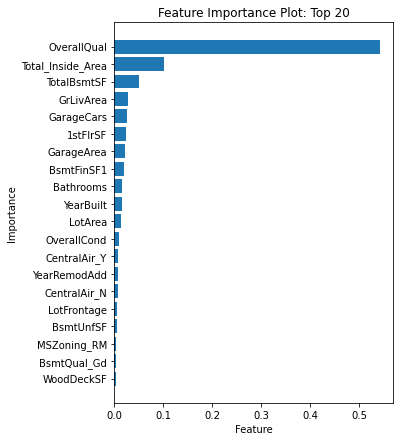

In [16]:
# variable importance plot
var_imp = pd.DataFrame({
    'feature': dev_train.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']).columns,
    'importance': rf_reg.feature_importances_
})
var_imp.sort_values("importance", ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(5, 7))
topn = 20
ax.barh(var_imp.head(topn).feature, var_imp.head(topn).importance)
ax.set_ylabel("Importance")
ax.set_xlabel("Feature")
ax.set_title("Feature Importance Plot: Top {}".format(topn))
ax.invert_yaxis()
print("")


## Lasso Regression

In [17]:
for i in [0, 1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]:

    # iterate over every vbalkue of alpha in the list, fit lasso regression
    model = Lasso(alpha = i)

    # copying Trevor's code, delete certain variables that don't matter
    model.fit(dev_train.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_train.LogSalePrice)

    # run 10-fold Cross validation to improve fit
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

    # calculate scores
    scores = cross_val_score(model, dev_train.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_train.LogSalePrice, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

    scores = absolute(scores)

    # calculate MAE, accuracy.
    print("Lasso alpha is equal to: ", i)
    print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))
    print('Accuracy:', model.score(dev_test.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_test.LogSalePrice))

<ipython-input-17-6bab5841d68a>:7: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(dev_train.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_train.LogSalePrice)
C:\Users\drkul\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\drkul\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2588836819241305, tolerance: 0.01657697804931841
  model = cd_fast.enet_coordinate_descent(


Lasso alpha is equal to:  0
Mean MAE: 0.083 (0.009)
Accuracy: 0.8881951482868266


C:\Users\drkul\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.258884896194987, tolerance: 0.01657697804931841
  model = cd_fast.enet_coordinate_descent(


Lasso alpha is equal to:  1e-10
Mean MAE: 0.083 (0.009)
Accuracy: 0.8881968037392565


C:\Users\drkul\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.829850478498875, tolerance: 0.01657697804931841
  model = cd_fast.enet_coordinate_descent(


Lasso alpha is equal to:  0.0001
Mean MAE: 0.076 (0.008)
Accuracy: 0.902239008344358


C:\Users\drkul\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02416699553504742, tolerance: 0.01657697804931841
  model = cd_fast.enet_coordinate_descent(


Lasso alpha is equal to:  0.001
Mean MAE: 0.075 (0.008)
Accuracy: 0.9049298023474491
Lasso alpha is equal to:  0.01
Mean MAE: 0.092 (0.010)
Accuracy: 0.8850411883732697
Lasso alpha is equal to:  0.1
Mean MAE: 0.113 (0.014)
Accuracy: 0.8304571535586247
Lasso alpha is equal to:  0.5
Mean MAE: 0.116 (0.014)
Accuracy: 0.8243256015784372
Lasso alpha is equal to:  1.0
Mean MAE: 0.121 (0.014)
Accuracy: 0.8103602715088101
Lasso alpha is equal to:  2.0
Mean MAE: 0.137 (0.015)
Accuracy: 0.7674453120433476
Lasso alpha is equal to:  10.0
Mean MAE: 0.160 (0.015)
Accuracy: 0.6937829849763466


In [18]:
# https://towardsdatascience.com/whats-the-difference-between-linear-regression-lasso-ridge-and-elasticnet-8f997c60cf29

# set asige log_sale_price in separate vectors
train_log_saleprice = dev_train.LogSalePrice
test_log_saleprice = dev_test.LogSalePrice

# drop unused variables
dev_train2 = dev_train.drop(columns = ["SalePrice", 'LogSalePrice', 'Id'])
dev_test2 = dev_test.drop(columns = ["SalePrice", 'LogSalePrice', 'Id'])

# standardize all values of all variables in data
scaler = StandardScaler()

scaler.fit(dev_train2)
dev_train2 = scaler.transform(dev_train2)

scaler.fit(dev_test2)
dev_test2 = scaler.transform(dev_test2)




In [19]:
for i in [0, 1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]:
    
    # run and fit lasso regression again, this time with completely standardized data
    model = Lasso(alpha = i)

    model.fit(dev_train2, train_log_saleprice)

    # 10-fold cross validation to improve fit
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

    # calculate scores and accuracy
    scores = cross_val_score(model, dev_train2, train_log_saleprice, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

    scores = absolute(scores)

    print("Lasso alpha is equal to: ", i)
    print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))
    print('Accuracy:', model.score(dev_test2, test_log_saleprice))

<ipython-input-19-fb793dd6367c>:6: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(dev_train2, train_log_saleprice)
C:\Users\drkul\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\drkul\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2588836819241216, tolerance: 0.01657697804931841
  model = cd_fast.enet_coordinate_descent(


Lasso alpha is equal to:  0
Mean MAE: 37.315 (34.837)
Accuracy: 0.8905152049044983


C:\Users\drkul\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2588474932627562, tolerance: 0.01657697804931841
  model = cd_fast.enet_coordinate_descent(


Lasso alpha is equal to:  1e-10
Mean MAE: 0.083 (0.009)
Accuracy: 0.8905152927423798
Lasso alpha is equal to:  0.0001
Mean MAE: 0.081 (0.009)
Accuracy: 0.8938848135482964
Lasso alpha is equal to:  0.001
Mean MAE: 0.076 (0.008)
Accuracy: 0.9027653574972858
Lasso alpha is equal to:  0.01
Mean MAE: 0.078 (0.009)
Accuracy: 0.9008106723358865
Lasso alpha is equal to:  0.1
Mean MAE: 0.149 (0.012)
Accuracy: 0.7309959356069126
Lasso alpha is equal to:  0.5
Mean MAE: 0.312 (0.023)
Accuracy: -0.001924764131719714
Lasso alpha is equal to:  1.0
Mean MAE: 0.312 (0.023)
Accuracy: -0.001924764131719714
Lasso alpha is equal to:  2.0
Mean MAE: 0.312 (0.023)
Accuracy: -0.001924764131719714
Lasso alpha is equal to:  10.0
Mean MAE: 0.312 (0.023)
Accuracy: -0.001924764131719714


In [20]:
for i in [0, 1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0, 25.0, 50.0, 75.0, 100.0]:

    # calculate ridge regression with completely standardized data
    model2 = Ridge(alpha = i)

    model2.fit(dev_train2, train_log_saleprice)

    # run 10-fold cross validation
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

    # calculate score
    scores = cross_val_score(model, dev_train2, train_log_saleprice, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

    scores = absolute(scores)

    # calculate MAE and Accuracy
    print("Lasso alpha is equal to: ", i)
    print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))
    print('Accuracy:', model2.score(dev_test2, test_log_saleprice))

Lasso alpha is equal to:  0
Mean MAE: 0.312 (0.023)
Accuracy: -2.8479057134900343e+28
Lasso alpha is equal to:  1e-10
Mean MAE: 0.312 (0.023)
Accuracy: 0.8919625095199696
Lasso alpha is equal to:  0.0001
Mean MAE: 0.312 (0.023)
Accuracy: 0.891914880952172
Lasso alpha is equal to:  0.001
Mean MAE: 0.312 (0.023)
Accuracy: 0.8919143500282952
Lasso alpha is equal to:  0.01
Mean MAE: 0.312 (0.023)
Accuracy: 0.8919090898818619
Lasso alpha is equal to:  0.1
Mean MAE: 0.312 (0.023)
Accuracy: 0.8918611465066325
Lasso alpha is equal to:  0.5
Mean MAE: 0.312 (0.023)
Accuracy: 0.8917301493330665
Lasso alpha is equal to:  1.0
Mean MAE: 0.312 (0.023)
Accuracy: 0.8916873157754721
Lasso alpha is equal to:  2.0
Mean MAE: 0.312 (0.023)
Accuracy: 0.8917845552751682
Lasso alpha is equal to:  10.0
Mean MAE: 0.312 (0.023)
Accuracy: 0.89345840951512
Lasso alpha is equal to:  25.0
Mean MAE: 0.312 (0.023)
Accuracy: 0.8956251377249224
Lasso alpha is equal to:  50.0
Mean MAE: 0.312 (0.023)
Accuracy: 0.8977451046

In [21]:
for i in [0, 1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]:

    # calculate Elastic Net with completely standardized data
    model3 = ElasticNet(alpha = i)

    model3.fit(dev_train2, train_log_saleprice)

    # 10-fold cross-validation to improve fit
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

    # calculate scores, MAE, and accuracy
    scores = cross_val_score(model, dev_train2, train_log_saleprice, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

    scores = absolute(scores)

    print("Lasso alpha is equal to: ", i)
    print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))
    print('Accuracy:', model3.score(dev_test2, test_log_saleprice))

<ipython-input-21-81db0400b488>:6: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model3.fit(dev_train2, train_log_saleprice)
C:\Users\drkul\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\drkul\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2588836819241216, tolerance: 0.01657697804931841
  model = cd_fast.enet_coordinate_descent(


Lasso alpha is equal to:  0
Mean MAE: 0.312 (0.023)
Accuracy: 0.8905152049044983


C:\Users\drkul\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.258865589147099, tolerance: 0.01657697804931841
  model = cd_fast.enet_coordinate_descent(


Lasso alpha is equal to:  1e-10
Mean MAE: 0.312 (0.023)
Accuracy: 0.8905152489467378
Lasso alpha is equal to:  0.0001
Mean MAE: 0.312 (0.023)
Accuracy: 0.8927045992817436
Lasso alpha is equal to:  0.001
Mean MAE: 0.312 (0.023)
Accuracy: 0.8995731636428297
Lasso alpha is equal to:  0.01
Mean MAE: 0.312 (0.023)
Accuracy: 0.9058063512033344
Lasso alpha is equal to:  0.1
Mean MAE: 0.312 (0.023)
Accuracy: 0.8272545388888419
Lasso alpha is equal to:  0.5
Mean MAE: 0.312 (0.023)
Accuracy: 0.2662198862534466
Lasso alpha is equal to:  1.0
Mean MAE: 0.312 (0.023)
Accuracy: -0.001924764131719714
Lasso alpha is equal to:  2.0
Mean MAE: 0.312 (0.023)
Accuracy: -0.001924764131719714
Lasso alpha is equal to:  10.0
Mean MAE: 0.312 (0.023)
Accuracy: -0.001924764131719714


In [22]:
for i in [0, 1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]:

    # Ridge Regression with minimally transofrmed data
    model4 = Ridge(alpha = i)

    model4.fit(dev_train.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_train.LogSalePrice)

    # 10-fold cross-validation
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

    # calculate scores, MAE, and Accuracy
    scores = cross_val_score(model, dev_train.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_train.LogSalePrice, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

    scores = absolute(scores)

    print("Lasso alpha is equal to: ", i)
    print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))
    print('Accuracy:', model4.score(dev_test.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_test.LogSalePrice))

Lasso alpha is equal to:  0
Mean MAE: 0.160 (0.015)
Accuracy: -4.793014457246503e+21


C:\Users\drkul\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.22403e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


Lasso alpha is equal to:  1e-10
Mean MAE: 0.160 (0.015)
Accuracy: 0.8888076653495216
Lasso alpha is equal to:  0.0001
Mean MAE: 0.160 (0.015)
Accuracy: 0.8888134413355854
Lasso alpha is equal to:  0.001
Mean MAE: 0.160 (0.015)
Accuracy: 0.8888660788874222
Lasso alpha is equal to:  0.01
Mean MAE: 0.160 (0.015)
Accuracy: 0.8893630766799778
Lasso alpha is equal to:  0.1
Mean MAE: 0.160 (0.015)
Accuracy: 0.8925636814409033
Lasso alpha is equal to:  0.5
Mean MAE: 0.160 (0.015)
Accuracy: 0.8971442595611743
Lasso alpha is equal to:  1.0
Mean MAE: 0.160 (0.015)
Accuracy: 0.8990225058030019
Lasso alpha is equal to:  2.0
Mean MAE: 0.160 (0.015)
Accuracy: 0.9005076469301752
Lasso alpha is equal to:  10.0
Mean MAE: 0.160 (0.015)
Accuracy: 0.9027353743005985


In [23]:
for i in [0, 1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]:

    # calculate elastic net with minimally transformed data
    model5 = ElasticNet(alpha = i)

    model5.fit(dev_train.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_train.LogSalePrice)

    # run 10-fold cross-validation
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

    # calculate scores, MAE, and accuracy
    scores = cross_val_score(model, dev_train.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_train.LogSalePrice, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

    scores = absolute(scores)

    print("Lasso alpha is equal to: ", i)
    print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))
    print('Accuracy:', model5.score(dev_test.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_test.LogSalePrice))

<ipython-input-23-d0ab544ac6d7>:6: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model5.fit(dev_train.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_train.LogSalePrice)
C:\Users\drkul\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\drkul\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2588836819241305, tolerance: 0.01657697804931841
  model = cd_fast.enet_coordinate_descent(


Lasso alpha is equal to:  0
Mean MAE: 0.160 (0.015)
Accuracy: 0.8881951482868266


C:\Users\drkul\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2588843377404157, tolerance: 0.01657697804931841
  model = cd_fast.enet_coordinate_descent(


Lasso alpha is equal to:  1e-10
Mean MAE: 0.160 (0.015)
Accuracy: 0.8881960140479364


C:\Users\drkul\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.683957320264252, tolerance: 0.01657697804931841
  model = cd_fast.enet_coordinate_descent(


Lasso alpha is equal to:  0.0001
Mean MAE: 0.160 (0.015)
Accuracy: 0.8997699170478848


C:\Users\drkul\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10033531620703595, tolerance: 0.01657697804931841
  model = cd_fast.enet_coordinate_descent(


Lasso alpha is equal to:  0.001
Mean MAE: 0.160 (0.015)
Accuracy: 0.9056487731715626
Lasso alpha is equal to:  0.01
Mean MAE: 0.160 (0.015)
Accuracy: 0.8896209626639713
Lasso alpha is equal to:  0.1
Mean MAE: 0.160 (0.015)
Accuracy: 0.8436083683752477
Lasso alpha is equal to:  0.5
Mean MAE: 0.160 (0.015)
Accuracy: 0.8291957864132364
Lasso alpha is equal to:  1.0
Mean MAE: 0.160 (0.015)
Accuracy: 0.8243089602550205
Lasso alpha is equal to:  2.0
Mean MAE: 0.160 (0.015)
Accuracy: 0.8102998894005177
Lasso alpha is equal to:  10.0
Mean MAE: 0.160 (0.015)
Accuracy: 0.7165680286968485


Epoch 1/400
8/8 [==============================] - 1s 23ms/step - loss: 149.6566 - val_loss: 148.0985
Epoch 2/400
8/8 [==============================] - 0s 4ms/step - loss: 148.1741 - val_loss: 146.7319
Epoch 3/400
8/8 [==============================] - 0s 5ms/step - loss: 146.8115 - val_loss: 145.4642
Epoch 4/400
8/8 [==============================] - 0s 4ms/step - loss: 145.5435 - val_loss: 144.2520
Epoch 5/400
8/8 [==============================] - 0s 6ms/step - loss: 144.2912 - val_loss: 143.0548
Epoch 6/400
8/8 [==============================] - 0s 4ms/step - loss: 143.0422 - val_loss: 141.7277
Epoch 7/400
8/8 [==============================] - 0s 3ms/step - loss: 141.6392 - val_loss: 140.2048
Epoch 8/400
8/8 [==============================] - 0s 5ms/step - loss: 140.0285 - val_loss: 138.4533
Epoch 9/400
8/8 [==============================] - 0s 3ms/step - loss: 138.1734 - val_loss: 136.5265
Epoch 10/400
8/8 [==============================] - 0s 3ms/step - loss: 136.1712 - val_los

8/8 [==============================] - 0s 5ms/step - loss: 1.3041 - val_loss: 1.2200
Epoch 84/400
8/8 [==============================] - 0s 4ms/step - loss: 1.2656 - val_loss: 1.1838
Epoch 85/400
8/8 [==============================] - 0s 4ms/step - loss: 1.2272 - val_loss: 1.1511
Epoch 86/400
8/8 [==============================] - 0s 5ms/step - loss: 1.1912 - val_loss: 1.1172
Epoch 87/400
8/8 [==============================] - 0s 5ms/step - loss: 1.1552 - val_loss: 1.0865
Epoch 88/400
8/8 [==============================] - 0s 4ms/step - loss: 1.1224 - val_loss: 1.0554
Epoch 89/400
8/8 [==============================] - 0s 5ms/step - loss: 1.0893 - val_loss: 1.0262
Epoch 90/400
8/8 [==============================] - 0s 6ms/step - loss: 1.0567 - val_loss: 0.9999
Epoch 91/400
8/8 [==============================] - 0s 2ms/step - loss: 1.0270 - val_loss: 0.9741
Epoch 92/400
8/8 [==============================] - 0s 5ms/step - loss: 1.0004 - val_loss: 0.9470
Epoch 93/400
8/8 [===============

8/8 [==============================] - 0s 5ms/step - loss: 0.2060 - val_loss: 0.2205
Epoch 167/400
8/8 [==============================] - 0s 3ms/step - loss: 0.2028 - val_loss: 0.2176
Epoch 168/400
8/8 [==============================] - 0s 7ms/step - loss: 0.1989 - val_loss: 0.2138
Epoch 169/400
8/8 [==============================] - 0s 4ms/step - loss: 0.1957 - val_loss: 0.2106
Epoch 170/400
8/8 [==============================] - 0s 3ms/step - loss: 0.1926 - val_loss: 0.2074
Epoch 171/400
8/8 [==============================] - 0s 3ms/step - loss: 0.1894 - val_loss: 0.2044
Epoch 172/400
8/8 [==============================] - 0s 6ms/step - loss: 0.1862 - val_loss: 0.2015
Epoch 173/400
8/8 [==============================] - 0s 3ms/step - loss: 0.1832 - val_loss: 0.1985
Epoch 174/400
8/8 [==============================] - 0s 4ms/step - loss: 0.1804 - val_loss: 0.1958
Epoch 175/400
8/8 [==============================] - 0s 5ms/step - loss: 0.1772 - val_loss: 0.1926
Epoch 176/400
8/8 [=====

Epoch 249/400
8/8 [==============================] - 0s 3ms/step - loss: 0.0769 - val_loss: 0.0892
Epoch 250/400
8/8 [==============================] - 0s 5ms/step - loss: 0.0765 - val_loss: 0.0886
Epoch 251/400
8/8 [==============================] - 0s 4ms/step - loss: 0.0763 - val_loss: 0.0888
Epoch 252/400
8/8 [==============================] - 0s 4ms/step - loss: 0.0754 - val_loss: 0.0874
Epoch 253/400
8/8 [==============================] - 0s 5ms/step - loss: 0.0749 - val_loss: 0.0868
Epoch 254/400
8/8 [==============================] - 0s 4ms/step - loss: 0.0746 - val_loss: 0.0867
Epoch 255/400
8/8 [==============================] - 0s 4ms/step - loss: 0.0739 - val_loss: 0.0856
Epoch 256/400
8/8 [==============================] - 0s 5ms/step - loss: 0.0735 - val_loss: 0.0852
Epoch 257/400
8/8 [==============================] - 0s 4ms/step - loss: 0.0729 - val_loss: 0.0852
Epoch 258/400
8/8 [==============================] - 0s 4ms/step - loss: 0.0724 - val_loss: 0.0848
Epoch 259/

8/8 [==============================] - 0s 6ms/step - loss: 0.0521 - val_loss: 0.0608
Epoch 332/400
8/8 [==============================] - 0s 4ms/step - loss: 0.0519 - val_loss: 0.0607
Epoch 333/400
8/8 [==============================] - 0s 2ms/step - loss: 0.0518 - val_loss: 0.0603
Epoch 334/400
8/8 [==============================] - 0s 5ms/step - loss: 0.0516 - val_loss: 0.0601
Epoch 335/400
8/8 [==============================] - 0s 5ms/step - loss: 0.0514 - val_loss: 0.0601
Epoch 336/400
8/8 [==============================] - 0s 5ms/step - loss: 0.0512 - val_loss: 0.0597
Epoch 337/400
8/8 [==============================] - 0s 5ms/step - loss: 0.0512 - val_loss: 0.0597
Epoch 338/400
8/8 [==============================] - 0s 4ms/step - loss: 0.0509 - val_loss: 0.0591
Epoch 339/400
8/8 [==============================] - 0s 5ms/step - loss: 0.0507 - val_loss: 0.0593
Epoch 340/400
8/8 [==============================] - 0s 6ms/step - loss: 0.0506 - val_loss: 0.0593
Epoch 341/400
8/8 [=====

<AxesSubplot:>

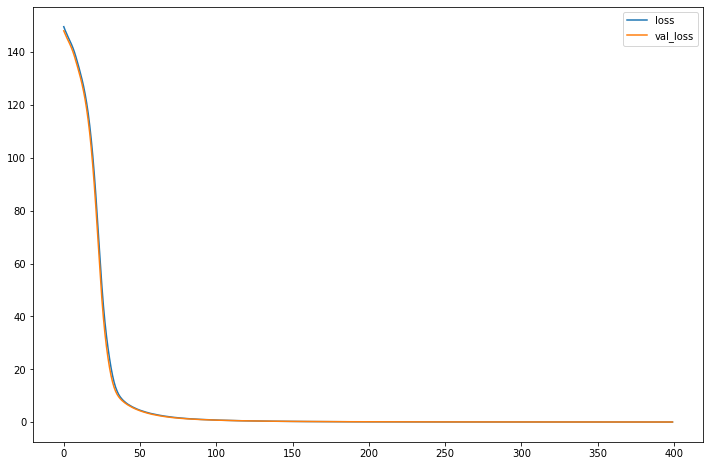

In [24]:
# Deva Neural Network attempt

# https://towardsdatascience.com/house-prices-prediction-using-deep-learning-dea265cc3154

import numpy as np
from keras.layers import Dense, Activation
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Sleecting fewer features for NN
dev_train_NN = dev_train[['LotArea', 'OverallQual','Remodeled', 
                          'Total_Inside_Area', 'Bathrooms', 'Expensive_neighborhood'
                         ,'LogSalePrice']]
dev_test_NN = dev_test[['LotArea', 'OverallQual','Remodeled', 
                          'Total_Inside_Area', 'Bathrooms', 'Expensive_neighborhood'
                         ,'LogSalePrice']]

# Splitting the dataset into the Training set and Test set
X_train = dev_train_NN.drop(columns = ['LogSalePrice'])
X_test = dev_test_NN.drop(columns = ['LogSalePrice'])
y_train = dev_train_NN.LogSalePrice
y_test = dev_test_NN.LogSalePrice

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# having 6 neuron is based on the number of available features
model = Sequential()
model.add(Dense(6,activation='relu'))
model.add(Dense(6,activation='relu'))
model.add(Dense(6,activation='relu'))
model.add(Dense(6,activation='relu'))
model.add(Dense(1))

# Compiling the ANN
model.compile(optimizer='Adam',loss='mean_squared_error')

# Fitting the ANN to the Training set
model.fit(x=X_train,y=y_train,
          validation_data=(X_test,y_test),
          batch_size=128,epochs=400)
model.summary()

loss_df = pd.DataFrame(model.history.history)
loss_df.plot(figsize=(12,8))



MAE: 0.1618881706152802
MSE: 0.04966127079684838
RMSE: 0.22284808905810338
VarScore: 0.6767825732883685


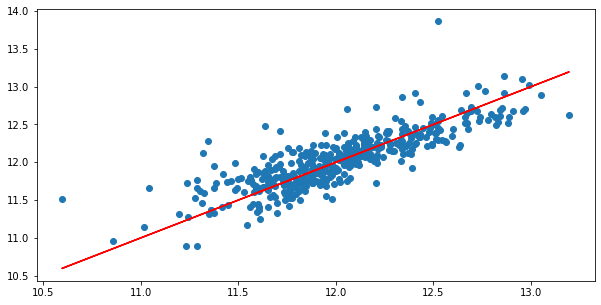

In [25]:
# Evaluate the NN

y_pred = model.predict(X_test)
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))  
print('MSE:', metrics.mean_squared_error(y_test, y_pred))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('VarScore:',metrics.explained_variance_score(y_test,y_pred))
# Visualizing Our predictions
fig = plt.figure(figsize=(10,5))
plt.scatter(y_test,y_pred)
# Perfect predictions
plt.plot(y_test,y_test,'r')

# Error Analysis


In [26]:
# Best Lasso Model from above

for i in [0.0001]:

    # iterate over every vbalkue of alpha in the list, fit lasso regression
    model = Lasso(alpha = i, tol = 0.0001, max_iter = 5000)

    # copying Trevor's code, delete certain variables that don't matter
    model.fit(dev_train.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_train.LogSalePrice)

    # run 10-fold Cross validation to improve fit
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

    # calculate scores
    scores = cross_val_score(model, dev_train.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_train.LogSalePrice, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

    scores = absolute(scores)

    # calculate MAE, accuracy.
    print("Lasso alpha is equal to: ", i)
    print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))
    print('Accuracy:', model.score(dev_test.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']), dev_test.LogSalePrice))

Lasso alpha is equal to:  0.0001
Mean MAE: 0.076 (0.008)
Accuracy: 0.9022927461498518


In [27]:
dev_predict = model.predict(dev_test.drop(columns = ["SalePrice", 'LogSalePrice', 'Id']))

Text(0.5, 1.0, 'Actual vs predicted for Best Lasso Model')

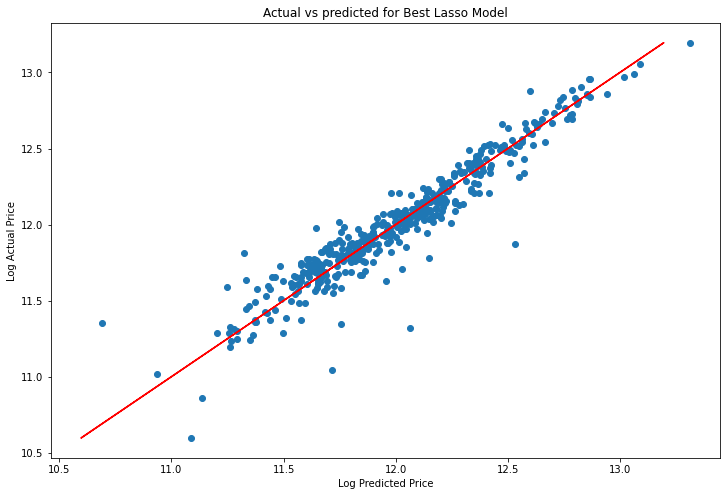

In [28]:
plt.figure(figsize=(12,8))
plt.scatter(dev_predict, dev_test.LogSalePrice)
plt.plot(dev_test.LogSalePrice, dev_test.LogSalePrice, 'r')
plt.xlabel('Log Predicted Price')
plt.ylabel('Log Actual Price')
plt.title('Actual vs predicted for Best Lasso Model')

Text(0.5, 1.0, 'Actual vs predicted for Best Lasso Model')

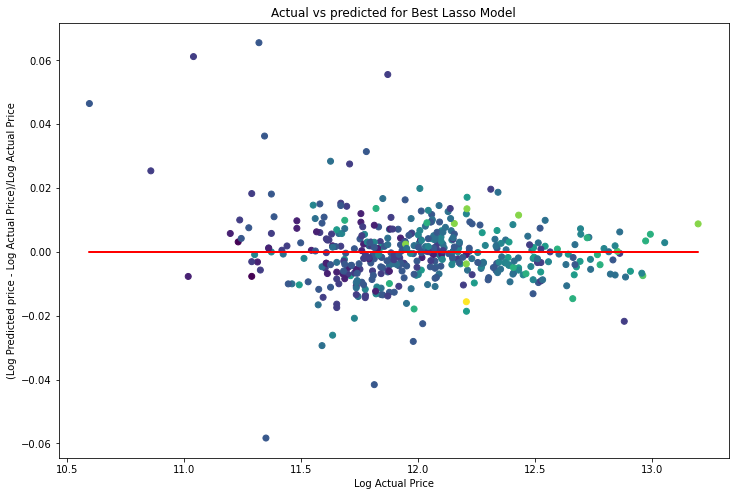

In [29]:
plt.figure(figsize=(12,8))
plt.scatter(dev_test.LogSalePrice, (dev_predict-dev_test.LogSalePrice)/dev_test.LogSalePrice, c = dev_test.TotRmsAbvGrd)
plt.plot(dev_test.LogSalePrice, np.zeros(len(dev_test.LogSalePrice)), 'r')
plt.xlabel('Log Actual Price')
plt.ylabel('(Log Predicted price - Log Actual Price)/Log Actual Price')
plt.title('Actual vs predicted for Best Lasso Model')

In [30]:
fraction_error = (dev_predict-dev_test.LogSalePrice)/dev_test.LogSalePrice

In [31]:
dev_test_with_error = pd.concat([dev_test, fraction_error.rename('fraction_error')], axis = 1)

In [32]:
dev_test_with_error

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,fraction_error
1163,1164,60.0,9.464983,4,4,1969,1969,0.0,1198,0,...,0,0,1,0,0,1,0,0,0,0.010869
111,112,69.0,8.955448,7,5,2000,2000,0.0,250,0,...,0,0,1,0,0,0,0,1,0,-0.001139
1273,1274,124.0,9.351145,6,7,1959,2006,84.0,719,0,...,0,0,1,0,0,0,0,1,0,0.002639
1147,1148,75.0,9.392662,7,7,1941,1950,0.0,275,0,...,0,0,1,0,0,0,0,1,0,0.003796
368,369,78.0,8.961879,5,6,1954,1954,200.0,540,0,...,0,0,1,0,0,0,0,1,0,0.001917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,251,55.0,8.584852,3,2,1940,1966,0.0,0,0,...,0,0,1,0,0,0,0,1,0,0.004205
76,77,69.0,9.044876,4,7,1956,1956,0.0,228,0,...,0,0,1,0,0,0,0,1,0,-0.012332
228,229,70.0,9.050289,5,5,1967,1967,0.0,842,0,...,0,0,1,0,0,0,0,1,0,-0.013384
1334,1335,24.0,7.769801,5,6,1970,1970,312.0,765,0,...,0,0,1,0,0,0,0,1,0,-0.009599


In [33]:
dev_test_with_error[np.abs(dev_test_with_error.fraction_error) > .02].loc(axis=1)['LotArea', 
                                                                                       'OverallQual', 
                                                                                      'OverallCond', 'YearRemodAdd',
                                                                                      'BedroomAbvGr',
                                                                                      'KitchenAbvGr', 
                                                                                      'TotRmsAbvGrd', 'YrSold',
                                                                                      'MoSold', 'Remodeled', 
                                                                                      'Total_Inside_Area', 'Bathrooms',
                                                                                    'LogSalePrice', 'fraction_error'].sort_values(by = ['fraction_error'])

,LotArea,OverallQual,OverallCond,YearRemodAdd,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,YrSold,MoSold,Remodeled,Total_Inside_Area,Bathrooms,LogSalePrice,fraction_error
88,9.044286,3,2,1982,2,1,6,2009,10,False,6.920672,1.0,11.350407,-0.058313
970,9.287301,4,4,1950,4,1,6,2006,12,False,7.083388,1.5,11.813030,-0.041594
557,9.309280,4,6,1950,3,1,7,2006,9,False,7.197435,1.5,11.589887,-0.029365
681,8.411833,5,5,2000,3,1,6,2009,7,False,7.326466,1.0,11.979385,-0.028054
48,8.402007,4,5,2008,2,3,8,2009,6,False,7.280697,2.0,11.635143,-0.026102
142,9.050172,5,4,1952,4,1,6,2010,6,True,7.233455,2.0,12.019743,-0.022503
1181,8.628198,8,5,2008,2,1,5,2008,11,True,7.409742,3.5,12.880292,-0.021750
630,9.104980,5,6,1991,3,1,8,2006,6,False,7.467371,1.0,11.728037,-0.020799
710,8.326033,3,6,2003,2,1,5,2008,7,False,6.591674,1.0,10.858999,0.025373
560,9.336180,5,6,1996,3,1,5,2010,5,False,7.238497,2.5,11.707670,0.027523


# PCA

In [34]:
test.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'Fence', 'MoSold', 'Y

In [35]:
train_subset = train[['Id', 'LotArea', 'Street', 'Neighborhood', 'OverallQual', 'OverallCond','YearBuilt', 
                      'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'YrSold', 'MoSold',
                     'SalePrice','Remodeled', 'Total_Inside_Area','Bathrooms',  
                      'LogSalePrice']][:1120]

dev_subset = train[['Id', 'LotArea', 'Street', 'Neighborhood', 'OverallQual', 'OverallCond','YearBuilt', 
                      'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'YrSold', 'MoSold',
                     'SalePrice','Remodeled', 'Total_Inside_Area','Bathrooms', 
                      'LogSalePrice']][1120:]

test_subset = test[['Id', 'LotArea', 'Street', 'Neighborhood', 'OverallQual', 'OverallCond','YearBuilt', 
                      'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'YrSold', 'MoSold',
                     'Remodeled', 'Total_Inside_Area','Bathrooms', 
                     ]]

In [36]:
def Change_Kitchen_Qual(df):
    ''' This function converts the kitchen quality levels to numberica values'''
    kitchen_qual_dict = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}
    return df.replace({'KitchenQual': kitchen_qual_dict})
    

In [37]:
train_subset_PCA = Change_Kitchen_Qual(train_subset)
dev_subset_PCA = Change_Kitchen_Qual(dev_subset)
test_subset_PCA = Change_Kitchen_Qual(test_subset)

In [38]:
train_subset_PCA = train_subset_PCA[['LotArea', 'OverallQual', 'OverallCond','YearBuilt', 
                      'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'YrSold', 'MoSold',
                     'SalePrice','Remodeled', 'Total_Inside_Area','Bathrooms']]

dev_subset_PCA = dev_subset_PCA[['LotArea', 'OverallQual', 'OverallCond','YearBuilt', 
                      'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'YrSold', 'MoSold',
                     'SalePrice','Remodeled', 'Total_Inside_Area','Bathrooms']]

test_subset_PCA = test_subset_PCA[['LotArea', 'OverallQual', 'OverallCond','YearBuilt', 
                      'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'YrSold', 'MoSold',
                     'Remodeled', 'Total_Inside_Area','Bathrooms']]

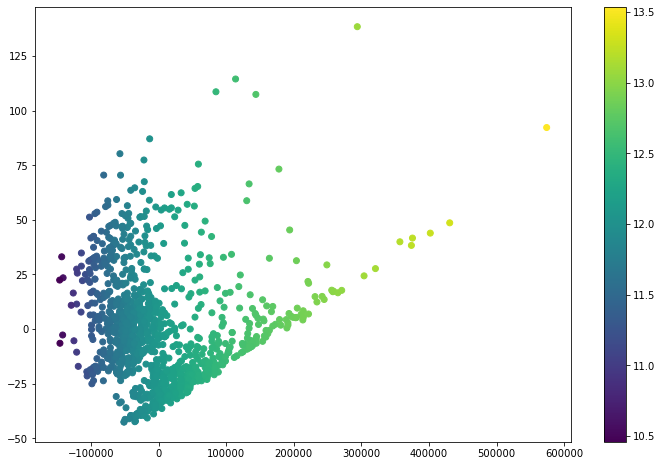

In [39]:
pca = PCA(n_components=2)
train_data_transformed = pca.fit_transform(train_subset_PCA)
dev_data_transformed = pca.transform(dev_subset_PCA)

plt.figure(figsize=(12,8))
plt.scatter(train_data_transformed[:,0], train_data_transformed[:,1], c = train_subset.LogSalePrice)
plt.colorbar()

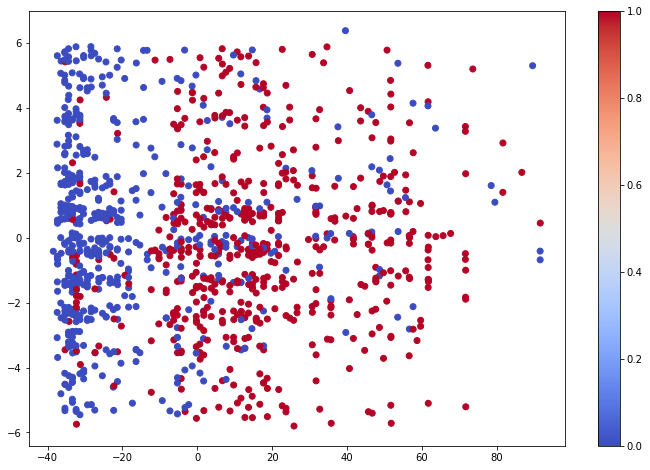

In [40]:
pca = PCA(n_components=2)
train_data_transformed = pca.fit_transform(train_subset_PCA.drop(['SalePrice'], axis=1))
dev_data_transformed = pca.transform(dev_subset_PCA.drop(['SalePrice'], axis=1))

plt.figure(figsize=(12,8))
plt.scatter(train_data_transformed[:,0], train_data_transformed[:,1], c = train_subset.LogSalePrice < 12,
           cmap = 'coolwarm')
plt.colorbar()

In [41]:
test_subset_PCA.head()

,LotArea,OverallQual,OverallCond,YearBuilt,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,YrSold,MoSold,Remodeled,Total_Inside_Area,Bathrooms
0,9.360655,5,6,1961,2,1,3,5,2010,6,True,6.797940,1.0
1,9.565704,6,6,1958,3,1,4,6,2010,6,True,7.192182,1.5
2,9.534595,5,5,1997,3,1,3,6,2010,3,False,7.395722,2.5
3,9.208138,6,6,1998,3,1,4,7,2010,6,True,7.380256,2.5
4,8.518193,8,5,1992,2,1,4,5,2010,1,True,7.154615,2.0


In [42]:
train_subset.head()

,Id,LotArea,Street,Neighborhood,OverallQual,OverallCond,YearBuilt,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,YrSold,MoSold,SalePrice,Remodeled,Total_Inside_Area,Bathrooms,LogSalePrice
0,1,9.041922,Pave,CollgCr,7,5,2003,3,1,Gd,8,2008,2,208500,True,7.444249,3.5,12.247694
1,2,9.169518,Pave,Veenker,6,8,1976,3,1,TA,6,2007,5,181500,True,7.140453,2.5,12.109011
2,3,9.328123,Pave,CollgCr,7,5,2001,3,1,Gd,6,2008,9,223500,False,7.487734,3.5,12.317167
3,4,9.164296,Pave,Crawfor,7,5,1915,3,1,Gd,7,2006,2,140000,False,7.448334,2.0,11.849398
4,5,9.565214,Pave,NoRidge,8,5,2000,4,1,Gd,9,2008,12,250000,True,7.695303,3.5,12.429216


In [43]:
train_subset['Expensive'] = train_subset.LogSalePrice > 12
dev_subset['Expensive'] = dev_subset.LogSalePrice > 12

In [44]:
dev_subset.head()

,Id,LotArea,Street,Neighborhood,OverallQual,OverallCond,YearBuilt,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,YrSold,MoSold,SalePrice,Remodeled,Total_Inside_Area,Bathrooms,LogSalePrice,Expensive
1121,1122,9.218705,Pave,CollgCr,7,5,2005,3,1,Gd,7,2006,7,212900,False,7.347300,2.0,12.268578,True
1122,1123,9.096724,Pave,Edwards,4,3,1956,3,1,TA,5,2009,10,112000,True,6.866933,1.0,11.626254,False
1123,1124,9.148997,Pave,Edwards,5,9,1947,2,1,TA,4,2009,6,118000,False,6.548219,1.5,11.678440,False
1124,1125,9.118773,Pave,Gilbert,7,5,1992,3,1,Gd,7,2007,7,163900,True,7.301148,2.5,12.007012,True
1125,1126,9.252825,Pave,NAmes,4,5,1955,2,1,Fa,5,2009,11,115000,True,6.912743,1.0,11.652687,False


In [45]:
train_subset_LGR = Change_Kitchen_Qual(train_subset)
dev_subset_LGR = Change_Kitchen_Qual(dev_subset)
test_subset_LGR = Change_Kitchen_Qual(test_subset)

In [46]:
train_subset_LGR = train_subset_LGR[['LotArea', 'OverallQual', 'OverallCond','YearBuilt', 
                      'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'YrSold', 'MoSold',
                     'SalePrice','Remodeled', 'Total_Inside_Area','Bathrooms',
                                     'Expensive', 'LogSalePrice']]

dev_subset_LGR = dev_subset_LGR[['LotArea', 'OverallQual', 'OverallCond','YearBuilt', 
                      'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'YrSold', 'MoSold',
                     'SalePrice','Remodeled', 'Total_Inside_Area','Bathrooms',  
                                 'Expensive', 'LogSalePrice']]

test_subset_LGR = test_subset_LGR[['LotArea', 'OverallQual', 'OverallCond','YearBuilt', 
                      'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'YrSold', 'MoSold',
                     'Remodeled', 'Total_Inside_Area','Bathrooms']]

In [47]:
# Logistic Regression
for C in [.0001, .001, .01, .1, 1, 2, 5, 10]:
        lgr = LogisticRegression(C = C, solver="liblinear", multi_class="auto")
        lgr_clf = lgr.fit(train_subset_LGR.drop(['Expensive', 'SalePrice', 'LogSalePrice'], 
                                            axis = 1), train_subset_LGR.Expensive)
        lgr_predicted = lgr_clf.predict(dev_subset_LGR.drop(['Expensive', 'SalePrice', 'LogSalePrice'], 
                                            axis = 1))
        print('''F-1 score for Logistic Regression with C = {:.4f}\
 is {:.3f}.'''.format(C, metrics.f1_score(dev_subset.Expensive, lgr_predicted, average="weighted")))

F-1 score for Logistic Regression with C = 0.0001 is 0.787.
F-1 score for Logistic Regression with C = 0.0010 is 0.825.
F-1 score for Logistic Regression with C = 0.0100 is 0.893.
F-1 score for Logistic Regression with C = 0.1000 is 0.914.
F-1 score for Logistic Regression with C = 1.0000 is 0.929.
F-1 score for Logistic Regression with C = 2.0000 is 0.932.
F-1 score for Logistic Regression with C = 5.0000 is 0.932.
F-1 score for Logistic Regression with C = 10.0000 is 0.929.


In [48]:
# Create data set for Lasso After LGR
train_subset_Lasso = pd.get_dummies(Change_Kitchen_Qual(train_subset.drop(['Id', 'SalePrice'], axis = 1)))
dev_subset_Lasso = pd.get_dummies(Change_Kitchen_Qual(dev_subset.drop(['Id', 'SalePrice'], axis = 1)))
test_subset_Lasso = pd.get_dummies(Change_Kitchen_Qual(test_subset.drop(['Id'], axis = 1)))

In [49]:
# Dev subset is missing 1 neighborhood
set(train_subset_Lasso.columns) - set(dev_subset_Lasso.columns)

{'Neighborhood_Blueste'}

In [50]:
dev_subset_Lasso['Neighborhood_Blueste'] = False

In [51]:
# Lasso for Not Expensive
train_subset_Lasso_Cheap = train_subset_Lasso[train_subset_Lasso.Expensive == False]
dev_subset_Lasso_Cheap = dev_subset_Lasso[dev_subset_Lasso.Expensive == False]
# Test_subset_Lasso_Cheap = test_subset_Lasso[test_subset_Lasso.Expensive == False]
for i in [.0001, .001, .01, .1, 1, 2, 5]:

    # iterate over every vbalkue of alpha in the list, fit lasso regression
    model = Lasso(alpha = i, tol = 0.0001, max_iter = 5000)

    # copying Trevor's code, delete certain variables that don't matter
    model.fit(train_subset_Lasso_Cheap.drop(columns = ['LogSalePrice']), 
              train_subset_Lasso_Cheap.LogSalePrice)

  
    # calculate MAE, accuracy.
    print("Lasso alpha is equal to: ", i)
    print('Accuracy:', model.score(dev_subset_Lasso_Cheap.drop(columns = ['LogSalePrice'])
                                   , dev_subset_Lasso_Cheap.LogSalePrice))

Lasso alpha is equal to:  0.0001
Accuracy: 0.47927243407643416
Lasso alpha is equal to:  0.001
Accuracy: 0.543192410510319
Lasso alpha is equal to:  0.01
Accuracy: 0.470118571335963
Lasso alpha is equal to:  0.1
Accuracy: 0.1014292229952587
Lasso alpha is equal to:  1
Accuracy: 0.08473280353377954
Lasso alpha is equal to:  2
Accuracy: 0.027268677687533383
Lasso alpha is equal to:  5
Accuracy: -0.0007535123938697819


In [52]:
# Lasso for Expensive
train_subset_Lasso_Expensive = train_subset_Lasso[train_subset_Lasso.Expensive == True]
dev_subset_Lasso_Expensive = dev_subset_Lasso[dev_subset_Lasso.Expensive == True]
# Test_subset_Lasso_Cheap = test_subset_Lasso[test_subset_Lasso.Expensive == False]
for i in [.0001, .001, .01, .1, 1, 2, 5]:

    # iterate over every vbalkue of alpha in the list, fit lasso regression
    model = Lasso(alpha = i, tol = 0.0001, max_iter = 5000)

    # copying Trevor's code, delete certain variables that don't matter
    model.fit(train_subset_Lasso_Expensive.drop(columns = ['LogSalePrice']), 
              train_subset_Lasso_Expensive.LogSalePrice)

  
    # calculate MAE, accuracy.
    print("Lasso alpha is equal to: ", i)
    print('Accuracy:', model.score(dev_subset_Lasso_Expensive.drop(columns = ['LogSalePrice'])
                                   , dev_subset_Lasso_Expensive.LogSalePrice))

Lasso alpha is equal to:  0.0001
Accuracy: 0.7108912114883276
Lasso alpha is equal to:  0.001
Accuracy: 0.7400505852200708
Lasso alpha is equal to:  0.01
Accuracy: 0.6721424204695049
Lasso alpha is equal to:  0.1
Accuracy: 0.41425925228726423
Lasso alpha is equal to:  1
Accuracy: 0.02828258573108433
Lasso alpha is equal to:  2
Accuracy: -0.004226688417635849
Lasso alpha is equal to:  5
Accuracy: -0.004226688417635849


In [53]:
dev_subset_Lasso.drop(columns = ['LogSalePrice']).shape

(338, 41)

In [54]:
dev_subset_Lasso.LogSalePrice.shape

(338,)

# Complexity plot

In [55]:
train_subset.columns

Index(['Id', 'LotArea', 'Street', 'Neighborhood', 'OverallQual', 'OverallCond',
       'YearBuilt', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'YrSold', 'MoSold', 'SalePrice', 'Remodeled',
       'Total_Inside_Area', 'Bathrooms', 'LogSalePrice', 'Expensive'],
      dtype='object')

In [56]:
dev_subset.columns

Index(['Id', 'LotArea', 'Street', 'Neighborhood', 'OverallQual', 'OverallCond',
       'YearBuilt', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'YrSold', 'MoSold', 'SalePrice', 'Remodeled',
       'Total_Inside_Area', 'Bathrooms', 'LogSalePrice', 'Expensive'],
      dtype='object')

In [57]:
train_subset = train[['Id', 'LotArea', 'Street', 'Neighborhood', 'OverallQual', 'OverallCond','YearBuilt', 
                      'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'YrSold', 'MoSold',
                     'SalePrice','Remodeled', 'Total_Inside_Area','Bathrooms',  
                      'LogSalePrice']][:1120]

dev_subset = train[['Id', 'LotArea', 'Street', 'Neighborhood', 'OverallQual', 'OverallCond','YearBuilt', 
                      'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'YrSold', 'MoSold',
                     'SalePrice','Remodeled', 'Total_Inside_Area','Bathrooms', 
                      'LogSalePrice']][1120:]

test_subset = test[['Id', 'LotArea', 'Street', 'Neighborhood', 'OverallQual', 'OverallCond','YearBuilt', 
                      'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'YrSold', 'MoSold',
                     'Remodeled', 'Total_Inside_Area','Bathrooms', 
                     ]]

train_subset['Expensive'] = train_subset.LogSalePrice > 12
dev_subset['Expensive'] = dev_subset.LogSalePrice > 12

In [58]:
def Categorize_Month(df):
    df['MoSold'] = df['MoSold'].map(str)
    return df

def Change_Kitchen_Qual(df):
    ''' This function converts the kitchen quality levels to numberica values'''
    kitchen_qual_dict = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}
    return df.replace({'KitchenQual': kitchen_qual_dict})

In [59]:
train_subset_LR = Change_Kitchen_Qual(Categorize_Month(train_subset))
dev_subset_LR = Change_Kitchen_Qual(Categorize_Month(dev_subset))
test_subset_LR = Change_Kitchen_Qual(Categorize_Month(test_subset))

cols = ['LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'KitchenQual', 'TotRmsAbvGrd', 
       'Total_Inside_Area','KitchenAbvGr',
        'Expensive', 'Bathrooms' , 'MoSold',
        'YrSold', 'BedroomAbvGr', 'Remodeled', 
         'Neighborhood', 'Street']
Complexity = []
Fit_Score = []
Gen_Score = []

for i in range(2, len(cols)):
    reg = LinearRegression()
    reg.fit(pd.get_dummies(train_subset_LR[cols[:i]]), train_subset_LR['LogSalePrice'])
    Fit_Score.append(reg.score(pd.get_dummies(train_subset_LR[cols[:i]]), train_subset_LR['LogSalePrice']))

    if 'Neighborhood' in cols[:i]:
        dev_subset_LR_Special = pd.get_dummies(dev_subset_LR[cols[:i]])
        dev_subset_LR_Special['Neighborhood_Blueste'] = False
        Gen_Score.append(reg.score(dev_subset_LR_Special, dev_subset_LR['LogSalePrice']))

    else:
        Gen_Score.append(reg.score(pd.get_dummies(dev_subset_LR[cols[:i]]), dev_subset_LR['LogSalePrice']))
    
    #Complexity.append(pd.get_dummies(train_subset_LR[cols[:i]]).shape[1])
    Complexity.append(i)

<ipython-input-58-aae711277732>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MoSold'] = df['MoSold'].map(str)


Text(0, 0.5, 'Accuracy')

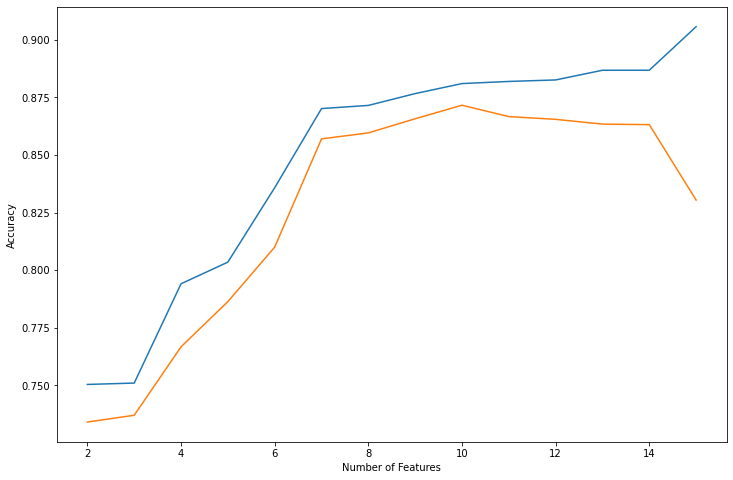

In [60]:
plt.figure(figsize=(12,8))
plt.plot(Complexity, Fit_Score)
plt.plot(Complexity, Gen_Score)
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')

# Logistic Reg Classify and Simple Linear Regression

In [61]:
cols = ['LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'KitchenQual', 'TotRmsAbvGrd', 
       'Total_Inside_Area','KitchenAbvGr',
        'Expensive', 'Bathrooms']

train_subset_LR = Change_Kitchen_Qual(Categorize_Month(train_subset))
dev_subset_LR = Change_Kitchen_Qual(Categorize_Month(dev_subset))
test_subset_LR = Change_Kitchen_Qual(Categorize_Month(test_subset))

for C in [.0001, .001, .01, .1, 1, 2, 5, 10, 100, 1000]:

    lgr = LogisticRegression(C = C, solver="liblinear", multi_class="auto")
    lgr_clf = lgr.fit(train_subset_LR[cols].drop(['Expensive'], 
                                        axis = 1), train_subset_LGR.Expensive)
    lgr_predicted = lgr_clf.predict(dev_subset_LR[cols].drop(['Expensive'], 
                                        axis = 1))
    print(metrics.f1_score(dev_subset_LR.Expensive, lgr_predicted, average="weighted"))

0.842984734709201
0.8580080573825877
0.8757396449704142
0.8816568047337278
0.8845820198045428
0.8816360689621995
0.8845820198045428
0.8845820198045428
0.9023112324887472
0.9201232398334521


<ipython-input-58-aae711277732>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MoSold'] = df['MoSold'].map(str)


In [62]:
cols = ['LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'KitchenQual', 'TotRmsAbvGrd', 
       'Total_Inside_Area','KitchenAbvGr',
        'Expensive', 'Bathrooms']

cols_test = ['LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'KitchenQual', 'TotRmsAbvGrd', 
       'Total_Inside_Area','KitchenAbvGr', 'Bathrooms']

train_subset_LR = Change_Kitchen_Qual(Categorize_Month(train_subset))
dev_subset_LR = Change_Kitchen_Qual(Categorize_Month(dev_subset))
test_subset_LR = Change_Kitchen_Qual(Categorize_Month(test_subset))



lgr = LogisticRegression(C = 1000, solver="liblinear", multi_class="auto")
lgr_clf = lgr.fit(train_subset_LR[cols].drop(['Expensive'], 
                                    axis = 1), train_subset_LGR.Expensive)
lgr_predicted = lgr_clf.predict(dev_subset_LR[cols].drop(['Expensive'], 
                                    axis = 1))
print(metrics.f1_score(dev_subset_LR.Expensive, lgr_predicted, average="weighted"))

# Predict for test
test_subset_LR['Expensive'] = lgr_clf.predict(test_subset_LR[cols_test])

0.9201232398334521


<ipython-input-58-aae711277732>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MoSold'] = df['MoSold'].map(str)


In [63]:
# Smallest, best Linear Regression with 10 features

cols = ['LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'KitchenQual', 'TotRmsAbvGrd', 
       'Total_Inside_Area','KitchenAbvGr',
        'Expensive', 'Bathrooms']


reg = LinearRegression()
reg.fit(pd.get_dummies(train_subset_LR[cols]), train_subset_LR['LogSalePrice'])
reg.predict(test_subset_LR[cols])

submission_df = pd.DataFrame({'Id':test_subset_LR.Id, 'SalePrice':np.exp(reg.predict(test_subset_LR[cols]))})

In [64]:
submission_df.to_csv('submission.csv', index = False)